In [ ]:
#pip install relativeImp
#pip install sklearn-gbmi
#pip install statsmodels
#pip install fbprophet

SyntaxError: invalid syntax (Temp/ipykernel_16004/985787819.py, line 2)

In [6]:
pip install fbprophet

In [ ]:
# IMPORTING LIBRARIES
import warnings
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from relativeImp import relativeImp
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, plot_partial_dependence
from sklearn_gbmi import *

from fbprophet import Prophet

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
#SETTINGS
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,15)})

In [3]:
#READ DATA
sample_data = pd.read_excel('data\SAMPLE_DATA.xlsx', header = 1)

In [4]:
#EXTRACT EXPLANATION 
explantion = sample_data['Variables']
sample_data = sample_data.drop(['Variables'], axis=1)

In [5]:
#TRANSPOSE DATA
transpose_sample_data = sample_data.T

In [6]:
#ADD HEADER
main_data = transpose_sample_data.rename(columns=transpose_sample_data.iloc[0]).drop(transpose_sample_data.index[0])

In [7]:
main_data.index = pd.to_datetime(main_data.index)

In [8]:
main_df = main_data.astype(float)

In [9]:
main_df['Date']= main_df.index
main_df['Month']= main_df.index.month
main_df['Year']= main_df.index.year
main_df['week_number'] = main_df.index.isocalendar().week

In [10]:
main_df.head(5)

,BRAND_A_VOLUME,BRAND_A_PRICE,COMPETITOR_A_PRICE,COMPETITOR_B_PRICE,COMPETITOR_C_PRICE,COMPETITOR_D_PRICE,COMPETITOR_E_PRICE,BRAND_A_New product,COMPETITOR_New product,BRAND_A_Insert,...,COMPETITOR_D_TOTAL_GRP,COMPETITOR_E_TOTAL_GRP,COMPETITOR_F_TOTAL_GRP,Real_Private_Consumption,BRAND_A_NDP,Teshir_Orani_BRAND_A,Day,Month,Year,Month-Year
2016-05-02,35232.8,12.593379,11.89,15.37,13.35,11.74,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,2,5,2016,5-2016
2016-05-09,155680.4,9.306888,9.51,9.65,9.94,8.36,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,9,5,2016,5-2016
2016-05-16,34356.6,12.539075,12.14,15.17,13.04,11.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,16,5,2016,5-2016
2016-05-23,34145.7,12.915243,12.69,15.61,13.49,11.61,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,23,5,2016,5-2016
2016-05-30,35328.5,12.678149,12.31,15.47,13.67,12.17,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,30,5,2016,5-2016


In [ ]:
main_df.describe().transpose()

### Correlation HeatMap

Pearson’s correlation coefficient is the test statistics that measures the statistical relationship, or association, between two continuous variables.  It is known as the best method of measuring the association between variables of interest because it is based on the method of covariance.  It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship.

In [11]:
corr = main_df.corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corr,cmap="YlGnBu")

* It is obvious that sales are inversely related to prices.
* Prices decrease on holidays.
* As the number of months increases, the rate of entering store magazines decreases.

### Key-Driver Analysis

Key Driver Analysis is a methodology branded in market research, called Relative Weights Analysis in Data Science (which can be either Shapley or Johnson's method). Key Drivers Analysis identifies how much each of the predictor variables (the drivers) are moving the depentor variable (key metric, key performance indicator aka KPI). In other words, "what are the drivers of your key metric?"

Relative importance or relative weight analysis is a method to “partition explained variance among multiple predictors to better understand the role played by each predictor in a regression equation” [(Tonidandel & LeBreton, 2011)](https://www.scotttonidandel.com/rwa-web). 

As drivers are often highly correlated with each other, typical multiple regression analysis would produce flawed indicators of driver importance. Instead, we adopt the relative weight analysis approach which accurately partitions variance among the correlated drivers.

In [16]:
yName =  'BRAND_A_VOLUME'

xNames = ['BRAND_A_PRICE', 'COMPETITOR_A_PRICE', 'COMPETITOR_B_PRICE',
       'COMPETITOR_C_PRICE', 'COMPETITOR_D_PRICE', 'COMPETITOR_E_PRICE',
       'BRAND_A_New product', 'COMPETITOR_New product', 'BRAND_A_Insert',
       'COMPETITOR_A_Insert', 'COMPETITOR_B_Insert',
       'COMPETITOR_C_Insert', 'COMPETITOR_D_Insert', 'BRAND_A_Redemption',
       'COMPETITOR_B_Redemption', 'COMPETITOR_C_Redemption',
       'COMPETITOR_D_Redemption', 'Kurban_Bayrami', 'Ramazan_Bayrami',
       'Anneler_Gunu', 'Babalar_Gunu', 'Sevgililier_Günü', 'Yilbasi',
       'Special_Day1', 'Special_Day2', 'Kadınlar_Günü',
       'BRAND_A_TOTAL_GRP', 'BRAND_A_ Total_Digital_Spending',
       'BRAND_A_OTHER_CATEGORY_1_GRP', 'BRAND_A_OTHER_CATEGORY_2_GRP',
       'COMPETITOR_B_TOTAL_GRP', 'COMPETITOR_C_TOTAL_GRP',
       'COMPETITOR_D_TOTAL_GRP', 'COMPETITOR_E_TOTAL_GRP',
       'COMPETITOR_F_TOTAL_GRP', 'Real_Private_Consumption',
       'BRAND_A_NDP', 'Teshir_Orani_BRAND_A','week_number']

results = relativeImp(main_df, outcomeName = yName, driverNames = xNames)
sorted_result = results.sort_values(by=['rawRelaImpt','normRelaImpt'],ascending=False)
sorted_result.iloc[:10]

,driver,rawRelaImpt,normRelaImpt
0,BRAND_A_PRICE,0.151319,17.055119
2,COMPETITOR_B_PRICE,0.116164,13.092788
4,COMPETITOR_D_PRICE,0.076695,8.644255
3,COMPETITOR_C_PRICE,0.049528,5.582263
13,BRAND_A_Redemption,0.049301,5.556718
36,BRAND_A_NDP,0.047541,5.358399
22,Yilbasi,0.047528,5.356926
24,Special_Day2,0.044598,5.026588
5,COMPETITOR_E_PRICE,0.041939,4.726898
1,COMPETITOR_A_PRICE,0.039838,4.490113


What is a good R-squared?
* <.3 is not good
* .3 - .4 is normal
* .4 - .5 is great
* .5 - .6 is exceptional
* \>.6 is dangerously high, possibly overfitting

In [17]:
print("R-SQUARED:"+str(sum(sorted_result[:6].rawRelaImpt) ))

0.8872328754030646

In [18]:
print('Key Sales Drivers:')
print(sorted_result[:6].driver)

Key Sales Drivers:
0          BRAND_A_PRICE
2     COMPETITOR_B_PRICE
4     COMPETITOR_D_PRICE
3     COMPETITOR_C_PRICE
13    BRAND_A_Redemption
36           BRAND_A_NDP
Name: driver, dtype: object


In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sorted_result[:6][['driver','normRelaImpt']].plot.bar(x='driver',rot=90)

We see the Key Sales Drivers for brand A in the graphic above. Of course, the most important factor affecting the sales of brand A is the prices of its competitors and itself. As a result, the priority issue for brand A is to determine the price strategy. It is very important both to keep the profit at the right level and to set a competitive price.

## Feature Interactions

If a machine learning model makes a prediction based on two features, we can decompose the prediction into four terms: a constant term, a term for the first feature, a term for the second feature and a term for the interaction between the two features.
The interaction between two features is the change in the prediction that occurs by varying the features after considering the individual feature effects.

## Price Elasticity

Most customers in most markets are sensitive to the price of a product or service, and the assumption is that more people will buy the product or service if it’s cheaper and less will buy it if it’s more expensive. But the phenomenon is more quantifiable than that, and price elasticity shows exactly how responsive customer demand is for a product based on its price.

This is the formula for price elasticity of demand:

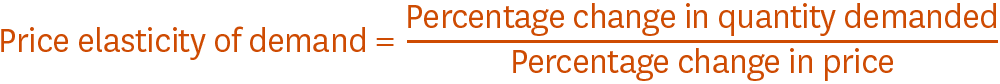

In [ ]:
#CALCULATE PRICE ELASTICITY
main_df['Elasticity'] = np.nan 

for i in range(1,len(main_df)):
  Q = (main_df['BRAND_A_VOLUME'][i] - main_df['BRAND_A_VOLUME'][i-1]) / ((main_df['BRAND_A_VOLUME'][i] + main_df['BRAND_A_VOLUME'][i-1]))/2 * 100
  P = (main_df['BRAND_A_PRICE'][i] - main_df['BRAND_A_PRICE'][i-1]) / ((main_df['BRAND_A_PRICE'][i] + main_df['BRAND_A_PRICE'][i-1]))/2 * 100
  main_df['Elasticity'][i] = Q / P

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
main_df['Elasticity'].plot()

In [ ]:
main_df.sort_values(by=['Elasticity'],ascending=True).head()

In [ ]:
main_df.loc['2016-08-15':'2016-08-23',:]

When we examine the data of the week with the lowest Price Elasticity value, we see that the sales decreased considerably despite a very small increase in price. If we try to interpret the reasons for this, we see that we have:

* In the week in which the price of Brand A increased, the other 3 competitors (Competitor A, B, C) decreased considerably in their prices. This suggests that customers are more likely to switch to other companies.
* Competitor D brand, which increased its price together with the A brand, is quite higher than the other companies as TOTAL_GRP that week. This may have affected the A brand as a negative sales return in terms of visibility.

In [ ]:
main_df.loc['2017-08-01':'2017-08-15',:]

When we examine the data of the week with the highest Price Elasticity value, we see that the sales have increased considerably despite the slight decrease in the price. If we try to interpret the reasons for this, we see that we have:

* In the week that brand A lowered its price, the prices of its other 3 competitors (Compatitor A, B, C) increased. This may have affected sales.
* In addition, the GRP value of brand A for that week is higher than other companies, that is, TV advertisements can be effective in increasing sales.

In [ ]:
x_value = main_df['BRAND_A_PRICE']
y_value = main_df['BRAND_A_VOLUME']
X = sm.add_constant(x_value)
model = sm.OLS(y_value, X)
result = model.fit()
    
if result.f_pvalue < 0.05:
  intercept, slope = result.params
  mean_price = np.mean(x_value)
  mean_quantity = np.mean(y_value)
  price_elasticity = (slope)*(mean_price/mean_quantity)

In [ ]:
price_elasticity

In [ ]:
According to the general average, the price elasticity of brand A is -1.84. In other words, against a 1% price increase, sales numbers decrease by 1.84%.